In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Slices/20190526_slices/201910/wfl/'
protein="TNR" #TNR,Agg,WFA,HABP

In [9]:
results = {"filename":[],
           "ecmchannelno":[],
           "exp condition":[],
          "spots mask":[]}
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif"): 
        if "stacks" not in str(filelist[i]): 
            if str(filelist[i][:-12]) not in str(results["filename"]):
                results["filename"].append(filelist[i])
                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                results["ecmchannelno"].append(1)

## Random image

TiffPages: invalid page offset (1058616)


Image name: 20191019_wfl647_mouse611_Series9.tif
Experimental condition: 20191019_wfl647_mouse611


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text yticklabel objects>)

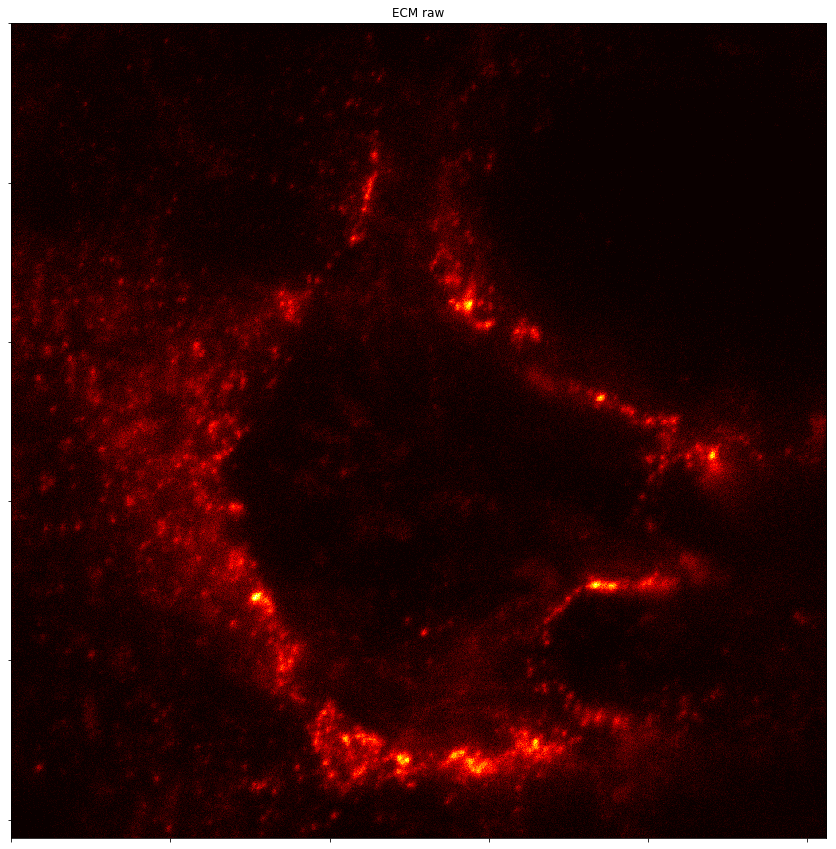

In [15]:
import pims
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]

randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
ecm_image_name=results["filename"][randomno]

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]


figure=plt.figure(figsize=(15,15))
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


In [16]:
for i in range(0,len(results["filename"])):
    results["spots mask"].append(np.nan)

In [17]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
ecm_channel_no=results["ecmchannelno"][first]
ecm_image_name=results["filename"][first]


ecm_image=pims.open(ecm_image_name)[0]
ecm_spots=deepcopy(ecm_image)
ecm_spots=ndi.median_filter(ecm_spots,size=5)

lower_man_threshold=np.min(ecm_spots)
upper_man_threshold=np.max(ecm_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    ecm_channel_no=results["ecmchannelno"][ii]
    ecm_image_name=results["filename"][ii]
    
    ecm_image=pims.open(ecm_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(ecm_image, 3)
    #ecm_image = ecm_image - lowpass
    #ecm_image[ecm_image<0]=0
    
    ecm_spots=deepcopy(ecm_image)
    lower_man_threshold=np.min(ecm_spots)
    upper_man_threshold=np.max(ecm_spots)

    if Threshold=="Li":
        ecm_image_threshold=threshold_li(ecm_image)      
    if Threshold=="Otsu":
        ecm_image_threshold=threshold_otsu(ecm_image)
    if Threshold=="Manual":
        ecm_image_threshold=Manual_Threshold
    
    ecm_spots[ecm_spots<ecm_image_threshold]=0
    ecm_spots=ndi.binary_opening(ecm_spots,iterations=Open)
    ecm_spots=ndi.binary_closing(ecm_spots,iterations=Close)
    results["spots mask"][ii]=ecm_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(ecm_spots)
    plt.imshow(ecm_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(ecm_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

TiffPages: invalid page offset (1058616)


interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…